# Basic SHAP Interaction Value Example in XGBoost

This notebook shows how the SHAP interaction values for a very simple function are computed. We start with a simple linear function, and then add an interaction term to see how it changes the SHAP values and the SHAP interaction values.

In [1]:
import xgboost
import numpy as np
import shap

## Explain a linear function with no interactions

In [2]:
# simulate some binary data and a linear outcome with an interaction term
# note we make the features in X perfectly independent of each other to make
# it easy to solve for the exact SHAP values
N = 2000
X = np.zeros((N,5))
X[:1000,0] = 1
X[:500,1] = 1
X[1000:1500,1] = 1
X[:250,2] = 1
X[500:750,2] = 1
X[1000:1250,2] = 1
X[1500:1750,2] = 1
X[:,0:3] -= 0.5
y = 2*X[:,0] - 3*X[:,1]

In [3]:
# ensure the variables are independent
np.cov(X.T)

array([[0.25012506, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.25012506, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.25012506, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [4]:
# and mean centered
X.mean(0)

array([0., 0., 0., 0., 0.])

In [5]:
# train a model with single tree
Xd = xgboost.DMatrix(X, label=y)
model = xgboost.train({
    'eta':1, 'max_depth':3, 'base_score': 0, "lambda": 0
}, Xd, 1)
print("Model error =", np.linalg.norm(y-model.predict(Xd)))
print(model.get_dump(with_stats=True)[0])

Model error = 0.0
0:[f1<0] yes=1,no=2,missing=1,gain=4500,cover=2000
	1:[f0<0] yes=3,no=4,missing=3,gain=1000,cover=1000
		3:leaf=0.5,cover=500
		4:leaf=2.5,cover=500
	2:[f0<0] yes=5,no=6,missing=5,gain=1000,cover=1000
		5:leaf=-2.5,cover=500
		6:leaf=-0.5,cover=500



In [6]:
# make sure the SHAP values add up to marginal predictions
pred = model.predict(Xd, output_margin=True)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xd)
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

0.0

If we build a summary plot we see that only features 1 and 2 have any effect, and that their effects only have two possible magnitudes (one for -0.5 and for 0.5).

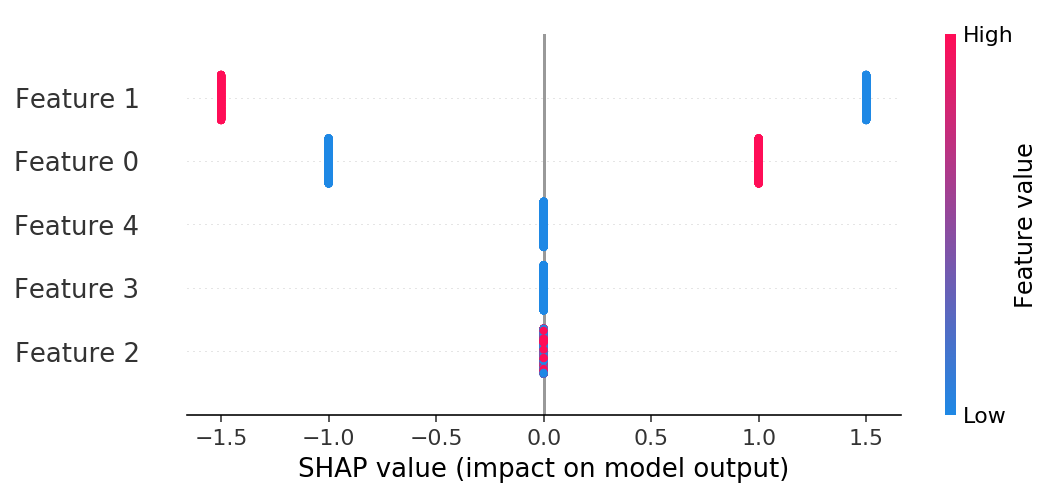

In [7]:
shap.summary_plot(shap_values, X)

In [8]:
# train a linear model
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(X, y)
lr_pred = lr.predict(X)
lr.coef_.round(2)

array([ 2., -3.,  0.,  0.,  0.])

In [9]:
# Make sure the computed SHAP values match the true SHAP values
# (we can compute the true SHAP values directly for this simple case)
main_effect_shap_values = lr.coef_ * (X - X.mean(0))
np.linalg.norm(shap_values - main_effect_shap_values)

2.1980906908667232e-13

### SHAP Interaction Values

Note that when there are no interactions present the SHAP interaction values are just a diagonal matrix with the SHAP values on the diagonal.

In [10]:
shap_interaction_values = explainer.shap_interaction_values(Xd)
shap_interaction_values[0]

array([[ 1. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -1.5,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ]], dtype=float32)

In [11]:
# ensure the SHAP interaction values sum to the marginal predictions
np.abs(shap_interaction_values.sum((1,2)) + explainer.expected_value - pred).max()

0.0

In [12]:
# ensure the main effects from the SHAP interaction values match those from a linear model
dinds = np.diag_indices(shap_interaction_values.shape[1])
total = 0
for i in range(N):
    for j in range(5):
        total += np.abs(shap_interaction_values[i,j,j] - main_effect_shap_values[i,j])
total

1.3590530773134374e-11

## Explain a linear model with one interaction

In [13]:
# simulate some binary data and a linear outcome with an interaction term
# note we make the features in X perfectly independent of each other to make
# it easy to solve for the exact SHAP values
N = 2000
X = np.zeros((N,5))
X[:1000,0] = 1

X[:500,1] = 1
X[1000:1500,1] = 1

X[:250,2] = 1
X[500:750,2] = 1
X[1000:1250,2] = 1
X[1500:1750,2] = 1

X[:125,3] = 1
X[250:375,3] = 1
X[500:625,3] = 1
X[750:875,3] = 1
X[1000:1125,3] = 1
X[1250:1375,3] = 1
X[1500:1625,3] = 1
X[1750:1875,3] = 1
X[:,:4] -= 0.4999 # we can't exactly mean center the data or XGBoost has trouble finding the splits
y = 2* X[:,0] - 3 * X[:,1] + 2 * X[:,1] * X[:,2]

In [14]:
X.mean(0)

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 0.e+00])

In [15]:
# train a model with single tree
Xd = xgboost.DMatrix(X, label=y)
model = xgboost.train({
    'eta':1, 'max_depth':4, 'base_score': 0, "lambda": 0
}, Xd, 1)
print("Model error =", np.linalg.norm(y-model.predict(Xd)))
print(model.get_dump(with_stats=True)[0])

Model error = 1.73650378306776e-06
0:[f1<0.000100002] yes=1,no=2,missing=1,gain=4499.4,cover=2000
	1:[f0<0.000100002] yes=3,no=4,missing=3,gain=1000,cover=1000
		3:[f2<0.000100002] yes=7,no=8,missing=7,gain=124.95,cover=500
			7:[f3<0.000100002] yes=15,no=16,missing=15,gain=6.04764e-06,cover=250
				15:leaf=0.9997,cover=125
				16:leaf=0.9997,cover=125
			8:leaf=-9.998e-05,cover=250
		4:[f2<0.000100002] yes=9,no=10,missing=9,gain=124.95,cover=500
			9:[f3<0.000100002] yes=17,no=18,missing=17,gain=7.78027e-05,cover=250
				17:leaf=2.9997,cover=125
				18:leaf=2.9997,cover=125
			10:[f3<0.000100002] yes=19,no=20,missing=19,gain=2.2528e-05,cover=250
				19:leaf=1.9999,cover=125
				20:leaf=1.9999,cover=125
	2:[f0<0.000100002] yes=5,no=6,missing=5,gain=1000,cover=1000
		5:[f2<0.000100002] yes=11,no=12,missing=11,gain=125.05,cover=500
			11:leaf=-3.0001,cover=250
			12:[f3<0.000100002] yes=21,no=22,missing=21,gain=2.2528e-05,cover=250
				21:leaf=-1.9999,cover=125
				22:leaf=-1.9999,cover=

In [16]:
# make sure the SHAP values add up to marginal predictions
pred = model.predict(Xd, output_margin=True)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xd)
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

2.3841858e-07

If we build a summary plot we see that now only features 3 and 4 don't matter, and that feature 1 can have four possible effect sizes due to interactions.

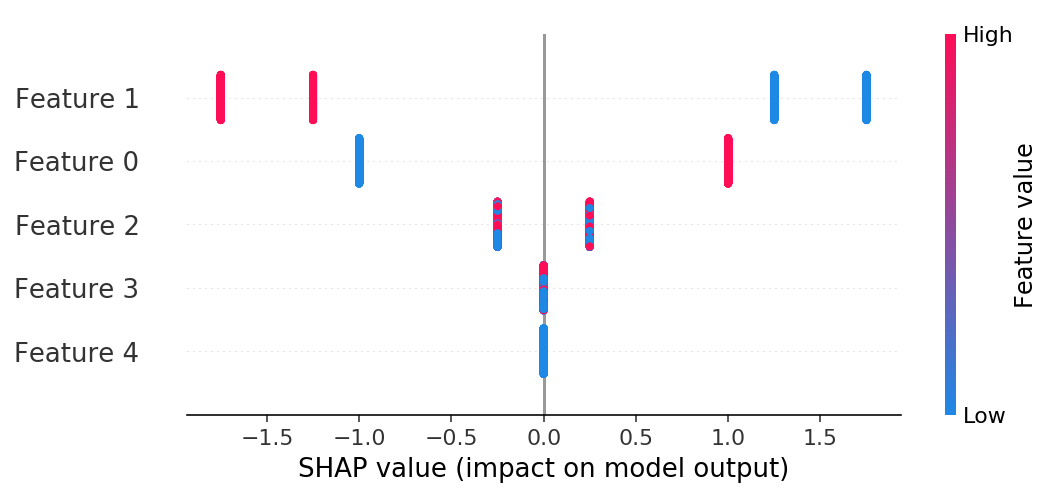

In [17]:
shap.summary_plot(shap_values, X)

In [18]:
# train a linear model
lr = linear_model.LinearRegression()
lr.fit(X, y)
lr_pred = lr.predict(X)
lr.coef_.round(2)

array([ 2., -3.,  0.,  0.,  0.])

In [19]:
# Note that the SHAP values no longer match the main effects because they now include interaction effects
main_effect_shap_values = lr.coef_ * (X - X.mean(0))
np.linalg.norm(shap_values - main_effect_shap_values)

15.8113893021767

### SHAP interaction values

In [20]:
# SHAP interaction contributions:
shap_interaction_values = explainer.shap_interaction_values(Xd)
shap_interaction_values[0].round(2)

array([[ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -1.5 ,  0.25, -0.  ,  0.  ],
       [ 0.  ,  0.25,  0.  ,  0.  ,  0.  ],
       [-0.  , -0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]], dtype=float32)

In [21]:
# ensure the SHAP interaction values sum to the marginal predictions
np.abs(shap_interaction_values.sum((1,2)) + explainer.expected_value - pred).max()

2.3841858e-07

In [22]:
# ensure the main effects from the SHAP interaction values match those from a linear model.
# while the main effects no longer match the SHAP values when interactions are present, they do match
# the main effects on the diagonal of the SHAP interaction value matrix
dinds = np.diag_indices(shap_interaction_values.shape[1])
total = 0
for i in range(N):
    for j in range(5):
        total += np.abs(shap_interaction_values[i,j,j] - main_effect_shap_values[i,j])
total

0.0005421147088888476

If we build a dependence plot for feature 0 we that it only takes two values and that these values are entirely dependent on the value of the feature (the value of feature 0 entirely determines it's effect because it has no interactions with other features).

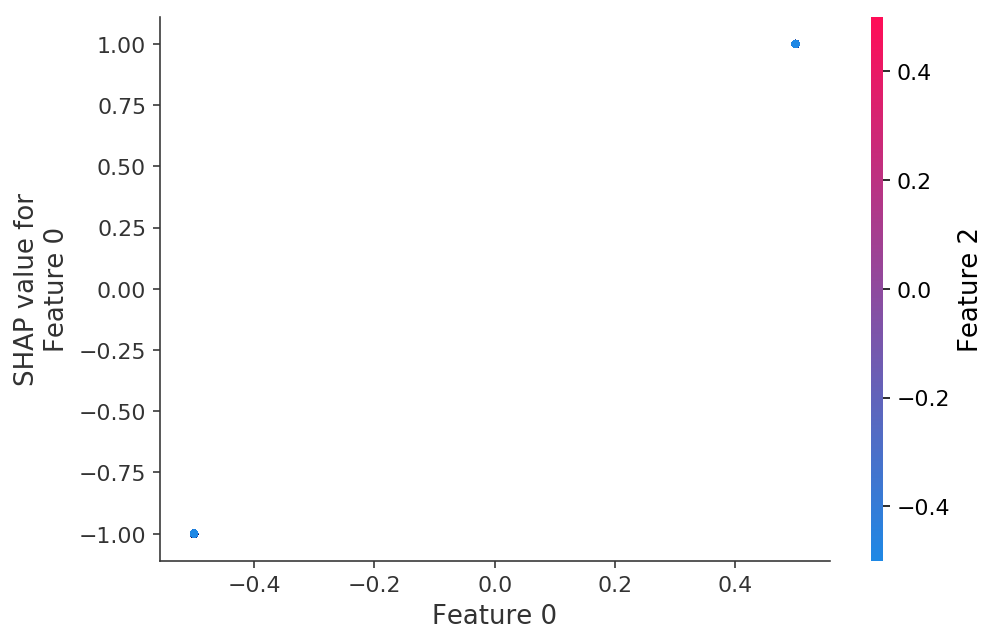

In [23]:
shap.dependence_plot(0, shap_values, X)

In contrast if we build a dependence plot for feature 2 we see that it takes 4 possible values and they are not entirely determined by the value of feature 2, instead they also depend on the value of feature 3. This vertical spread in a dependence plot represents the effects of non-linear interactions.

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


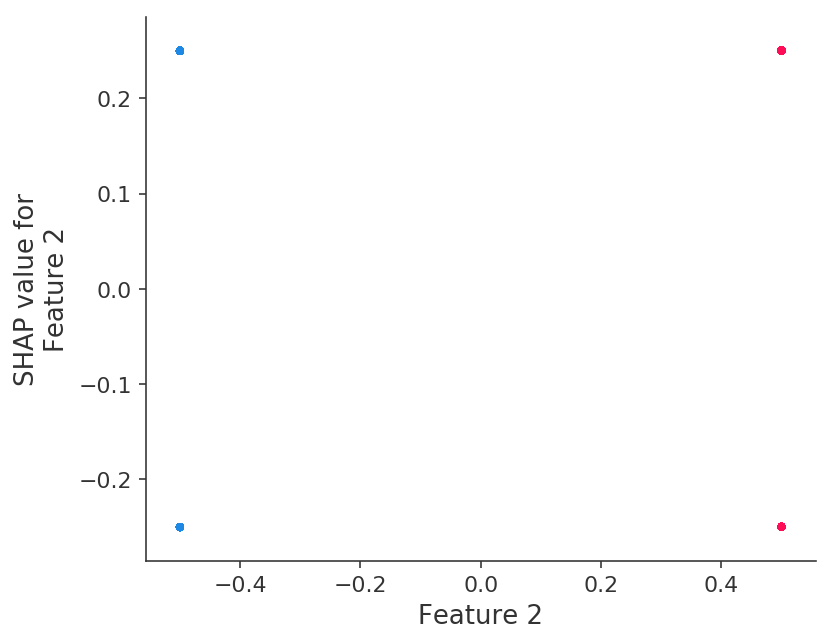

In [24]:
shap.dependence_plot(2, shap_values, X)